# Fractal Embeddings Demo Notebook

This walks through some of the functionality contained in this repo with example results.

#### Main Point of This File
- To describe code functionality 
- To steal code snippets and shell commands
- A playground for development

In [10]:
import configparser
import src.embed_text_cohere as emb
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, to_tree
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import importlib
import src.dimensionality_reduction as dr
importlib.reload(dr)


<module 'src.dimensionality_reduction' from '/Users/aidanbx/CS/LociMaps/fractal-embeddings/src/dimensionality_reduction.py'>

---

# Creating Embeddings from Text Directories

---

The `embed_text_cohere.py` script takes a directory containing text files and generates embeddings using Cohere's API. The embeddings are saved as a DataFrame in a `.csv` file. This script supports recursive search for `.md` files in the input directory and can handle API rate limits.

Here's an example of how to run the script from the command line:

```bash
python src/embed_text_cohere.py -i ./data -e output_embeddings.csv -c config.ini
```

Review the script to understand the command line arguments. Briefly, the -i input dir is being stored in the -e embedding file and a -n npz file, with an api key found in -c config.ini

Now let's run the script using the provided data directories.

##### Via Command Line

In [8]:
response = input("Are you sure you want to generate the embeddings again? (Y/N))")

if response == 'Y' or response == 'y' or response == 'yes' or response == 'Yes':
    !python src/embed_text_cohere.py -i ./data/memory -e ./demo_data/memory_embeddings.csv -n -c config.ini
    !python src/embed_text_cohere.py -i ./data/my-second-brain -e ./demo_data/my_second_brain_embeddings.csv -n -c config.ini
else:
    print("Skipping embedding generation.")

Embedding text: 100%|█████████████████████████████| 7/7 [00:14<00:00,  2.08s/it]


##### Programmatically

In [13]:
import configparser
import src.embed_text_cohere as emb

config = configparser.ConfigParser()
config.read('./config.ini')                 # ADD CONFIG FILE WITH API KEY IN IT
api_key = config.get('cohere', 'api_key')

response = input("Are you sure you want to generate the embeddings again? (Y/N))")

if response == 'Y' or response == 'y' or response == 'yes' or response == 'Yes':
    print('Generating embeddings...')
    memory_folder_name = './data/memory'
    my_second_brain_folder_name = './data/my-second-brain'

    # Read the input data
    memory_df = emb.read_input_data(memory_folder_name)
    my_second_brain_df = emb.read_input_data(my_second_brain_folder_name)

    # Create embeddings
    memory_df_embeddings = emb.create_embeddings(memory_df, api_key)
    my_second_brain_df_embeddings = emb.create_embeddings(my_second_brain_df, api_key)

    # Save embeddings as a .npz file
    emb.save_embeddings_npz(memory_df_embeddings, './demo_data/memory_embeddings.npz')
    emb.save_embeddings_npz(my_second_brain_df_embeddings, './demo_data/my_second_brain_embeddings.npz')
else:
    print('Exiting...')

Exiting...


## Load in previously generated embeddings

After running the above commands, you should have two `.csv` files containing embeddings for your data: `memory_embeddings.csv`and `my_second_brain_embeddings.csv`. You can load these files using pandas and visualize the embeddings or perform further analysis.

In [14]:
import pandas as pd

memory_embeddings_df = pd.read_csv('./demo_data/memory_embeddings.csv')
my_second_brain_embeddings_df = pd.read_csv('./demo_data/my_second_brain_embeddings.csv')

memory_embeddings_df.head()


,filename,index,chunk_text,embedding,links
0,Heretics of Dune,0,# Heretics of Dune ![rw-book-cover](https://im...,"[1.4345703, -0.37695312, 0.18273926, -0.636718...","['Frank Herbert', 'Books', 'Psychedelics', 'Sc..."
1,CSC 581,1,"--- **Status::** #🗺️ **Tags::** [[MOC]], [[Win...","[0.92285156, -0.5053711, 0.7392578, 0.30615234...","['MOC', 'Winter 2023']"
2,Tensorflow Mac M1,2,## AAAh [Good post on SO](https://stackoverflo...,"[1.8417969, 0.6347656, 0.027954102, 1.9462891,...",['Programming Notes']
3,Tensorflow Mac M1,2,optimizer=tf.keras.optimizers.legacy.Adam(lear...,"[3.5527344, 0.11090088, 0.33618164, 1.2988281,...",['Programming Notes']
4,Snowflake,3,## Snowflake Here's to you - You doubters of m...,"[0.80810547, 1.3378906, -0.18164062, 0.0483093...","['Poetry', 'My Writings']"


In [15]:
my_second_brain_embeddings_df.head()

,filename,index,chunk_text,embedding,links
0,Welcome in my mind 🧠,0,"## Who I am? I'm **Anthony**, a `Date.today.ye...","[0.8691406, -0.91748047, 1.21875, -1.6054688, ...",[]
1,Welcome in my mind 🧠,0,want. Here's a hint: you can just watch the su...,"[0.75634766, -0.33984375, 0.22790527, -1.01953...",[]
2,README,1,*You'll have a better browsing experience of t...,"[1.0322266, -1.8320312, 0.36694336, -0.9697265...",[]
3,README,1,deep into a wide variety of fields and engage ...,"[1.2236328, -0.5444336, -0.43579102, 0.4089355...",[]
4,Contact me 💌,2,## Want to get in touch? 😊 I'd love to hear fr...,"[-0.6777344, 0.38598633, 1.8916016, -2.1796875...",[]


---

# Dimensionality Reduction

---

We'll perform dimensionality reduction on the embeddings to visualize them in a lower-dimensional space. The `dimensionality_reduction.py` script can perform PCA, t-SNE, and UMAP dimensionality reduction methods. 

### Combining Embeddings

Before performing dimensionality reduction, let's combine the two sets of embeddings into a single file. We'll use numpy to load, concatenate, and save the embeddings.

In [6]:
import numpy as np

memory_embeddings = np.load('./demo_data/memory_embeddings.npz', allow_pickle=True)
my_second_brain_embeddings = np.load('./demo_data/my_second_brain_embeddings.npz', allow_pickle=True)

combined_embeddings = np.concatenate((memory_embeddings['embeddings'], my_second_brain_embeddings['embeddings']), axis=0)
combined_filenames = np.concatenate((memory_embeddings['filenames'], my_second_brain_embeddings['filenames']), axis=0)
np.savez('./demo_data/combined_embeddings.npz', filenames=combined_filenames, embeddings=combined_embeddings)

### Running Dimensionality Reduction
Now we'll run the dimensionality_reduction.py script on the combined embeddings. This script supports PCA, t-SNE, and UMAP reduction methods. You can specify which methods to use with the `-r` argument. By default, it will run all methods.

Rundown of the following command:

Reduce the -e embeddings npz, -o output the results to npz, and -p plot the results

##### Via Command Line

In [39]:
response = input("Are you sure you want to generate the reductions again? (Y/N))")

if response == 'Y' or response == 'y' or response == 'yes' or response == 'Yes':
    !python src/dimensionality_reduction.py -e demo_data/combined_embeddings.npz -o demo_data/combined_reduced_embeddings.npz -p
else:
    print('Exiting...')

Running PCA 5
Running t-SNE 2
Running UMAP 5
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Running UMAP 2
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


##### Programmatically

In [18]:
import importlib
import src.dimensionality_reduction as dr
importlib.reload(dr)

response = input("Are you sure you want to generate the reductions again? (Y/N))")

if response == 'Y' or response == 'y' or response == 'yes' or response == 'Yes':
    reduced_embeddings = dr.run_dimensionality_reduction(combined_embeddings, ['pca5', 'umap2'])
    np.savez('./demo_data/combined_reduced_embeddings.npz', **reduced_embeddings)


After running the above command, you should have an NPZ file `demo_data/combined_reduced_embeddings.npz` containing reduced embeddings for the combined dataset. You can load this file using numpy and visualize the embeddings or perform further analysis.

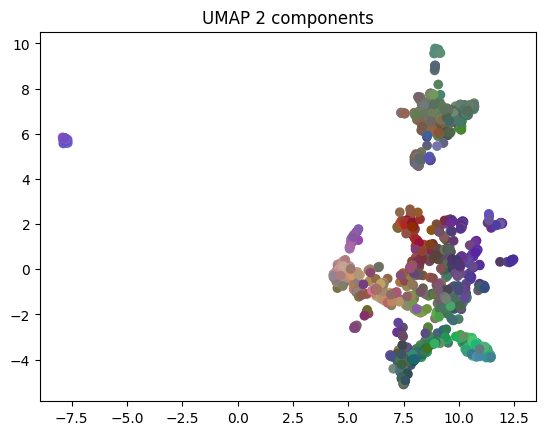

In [11]:
reduced_embeddings = np.load('demo_data/combined_reduced_embeddings.npz')
dr.plot_embeddings(reduced_embeddings["umap2"], reduced_embeddings["pca5"][:, 2:5], "UMAP 2 components")

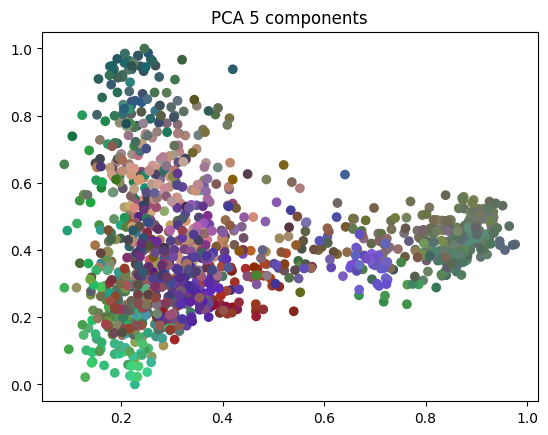

In [15]:
dr.plot_embeddings(reduced_embeddings["pca5"], reduced_embeddings["pca5"][:, 2:5], "PCA 5 components")

---

# Data Thus Far

---

In [4]:
reduced_npz = np.load('./demo_data/combined_reduced_embeddings.npz', allow_pickle=True)
embedding_npz = np.load('./demo_data/combined_embeddings.npz', allow_pickle=True)

filenames = embedding_npz['filenames']
embeddings = embedding_npz['embeddings']
umap2 = reduced_npz['umap2']
pca5 = reduced_npz['pca5']

---

# Clustering

---

### Generate Linkage Matrix (Perform Agglomerative Clustering)

In [5]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, to_tree
import matplotlib.pyplot as plt

# Perform hierarchical clustering using the 'ward' method
linked = linkage(embeddings, method='ward')

In [8]:
a = [[1,2,3], [4,5,6], [7,8,9]]
# turns list of lists into 2d np array

# linked[:10,2:4]

array([[0.        , 2.        ],
       [0.        , 2.        ],
       [0.        , 3.        ],
       [0.        , 2.        ],
       [0.        , 2.        ],
       [0.        , 2.        ],
       [4.46340296, 2.        ],
       [5.20446278, 2.        ],
       [6.0414261 , 2.        ],
       [8.5319706 , 2.        ]])

### Merge leaves and links together for labeling etc.

In [9]:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
def create_link_values(linkage_matrix, leaf_values,
                      merge_function = lambda cluster1_val, cluster2_val, weight: cluster1_val * (1 - weight) + cluster2_val * weight,
                      weight_function = lambda cluster1_size, cluster2_size: cluster2_size / (cluster1_size + cluster2_size)):
    # Merge function takes val1, val2, and a weight (0-1, 0 preferences val1, 1 preferences val2) and returns a merged value

    num_leaves = len(leaf_values)
    
    new_values = leaf_values.copy()
    for row in linkage_matrix:
        cluster1_id = int(row[0])
        cluster2_id = int(row[1])

        if cluster1_id < num_leaves: # it is a sample/leaaf
            cluster1_size = 1
        else:
            cluster1_size = linkage_matrix[num_leaves - cluster1_id][-1]
        
        if cluster2_id < num_leaves: # it is a sample/leaf
            cluster2_size = 1
        else:
            cluster2_size = linkage_matrix[num_leaves - cluster2_id][-1]

        # If a cluster is huge and is merged with a leaf, the weight should preference the cluster
        # Can try different weighting here
        weight = weight_function(cluster1_size, cluster2_size)

        merged_cluster_value = merge_function(new_values[cluster1_id], new_values[cluster2_id], weight)

        new_values = np.concat((new_values, merged_cluster_value), axis=0)

    return new_values

### Generates Link Colors and Dataframe

In [10]:
import matplotlib.colors as mcolors

# Adds colors for linkages by blending the leave colors together, recursively
# if t is 1, color2 is returned, if it is 0, color1 is
def blend_colors(color1, color2, t):
    r1, g1, b1 = color1
    r2, g2, b2 = color2

    r = r1 * (1 - t) + r2 * t
    g = g1 * (1 - t) + g2 * t
    b = b1 * (1 - t) + b2 * t

    return np.array([r, g, b])

pca_colors = pca5[:, 2:5]

link_leaf_colors = create_link_values(linked, pca_colors, merge_function=blend_colors)

# converts rgb (0-1) to hex
link_leaf_colors = [mcolors.to_hex(color) for color in link_leaf_colors]

In [11]:
num_leaves = len(filenames)

# Creates a 2d array matching the linkage matrix but is leafid, leafid, 0, 1 
leaves = [[leaf, leaf, 0, 1] for leaf in range(len(filenames))]

# Creates a dataframes with the leaves, with the index as leafid
linked_df = pd.DataFrame(leaves, columns=['id1', 'id2', 'distance', 'size'], index=range(num_leaves))

# Adds the linkage matrix to the dataframe (using concat), indexing it properly from num_samples to num_samples + num_links
linked_df = pd.concat([linked_df, pd.DataFrame(linked, columns=['id1', 'id2', 'distance', 'size'], index=range(num_leaves, num_leaves + len(linked)))])

# Adds the colors to the dataframe
linked_df['color'] = link_leaf_colors

# Adds filenames to the dataframe, adding None for the non-leaf nodes
linked_df['filename'] = filenames.tolist() + [None] * len(linked)

linked_df

,id1,id2,distance,size,color,filename
0,0.0,0.0,0.000000,1.0,#9d885f,Heretics of Dune
1,1.0,1.0,0.000000,1.0,#1b666e,CSC 581
2,2.0,2.0,0.000000,1.0,#4948a5,Tensorflow Mac M1
3,3.0,3.0,0.000000,1.0,#3e43a3,Tensorflow Mac M1
4,4.0,4.0,0.000000,1.0,#9e7b78,Snowflake
...,...,...,...,...,...,...
2474,2468.0,2469.0,495.364608,399.0,#7b4070,None
2475,2472.0,2474.0,587.872737,588.0,#646771,None
2476,2471.0,2475.0,620.426959,745.0,#8d7b74,None
2477,2459.0,2476.0,717.706050,903.0,#71706c,None


/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128140 (\N{LOVE LETTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


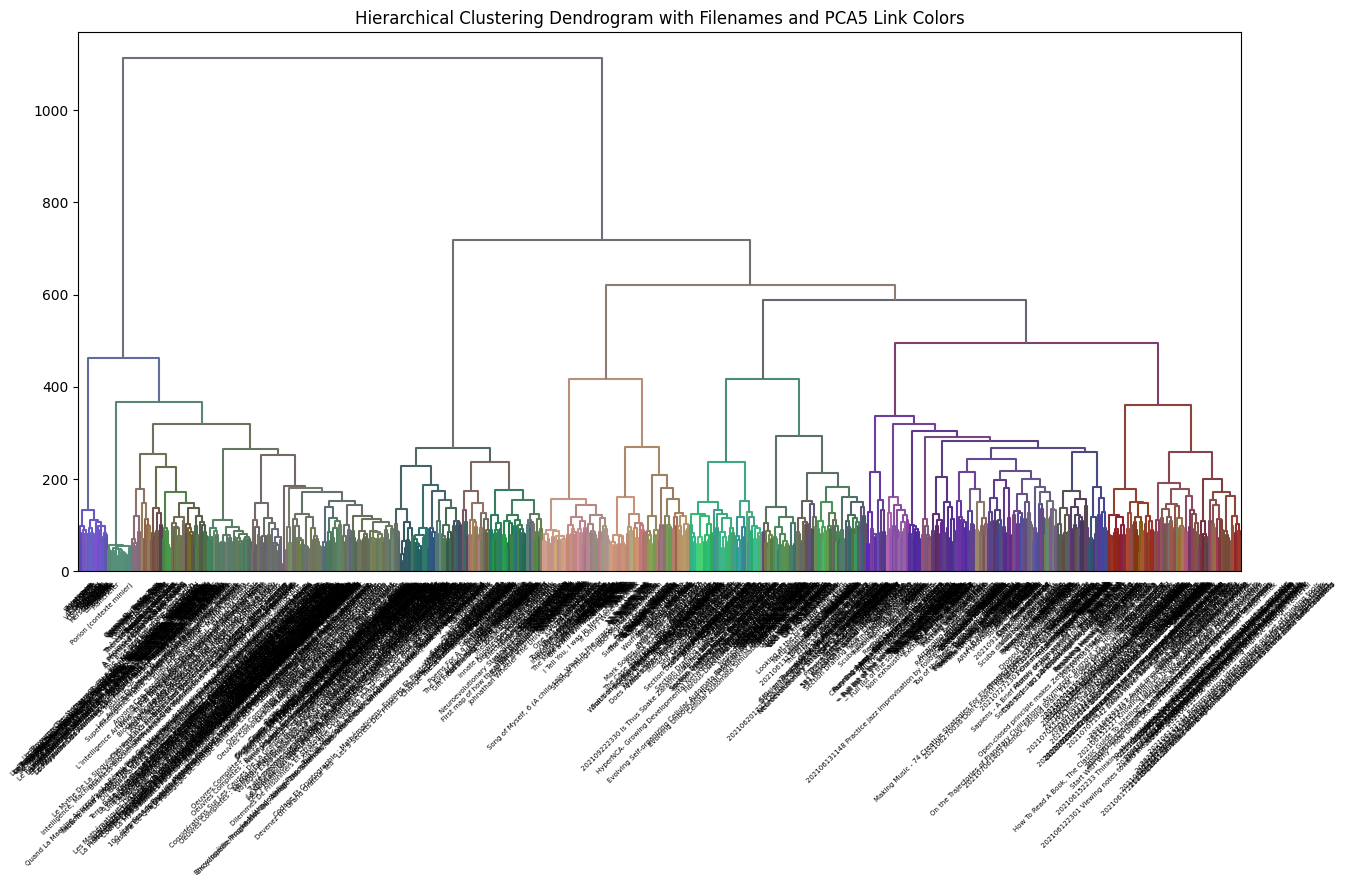

In [12]:
# Plot the dendrogram with custom labels and link colors
plt.figure(figsize=(15, 7))
dendrogram(linked, leaf_rotation=45, labels=filenames, link_color_func=lambda link_id: link_leaf_colors[link_id])
plt.title('Hierarchical Clustering Dendrogram with Filenames and PCA5 Link Colors')
plt.show()

In [1]:
linked

NameError: name 'linked' is not defined

In [35]:
def midpoint(icoord, dcoord):
    return (0.5 * sum(icoord[1:3]), dcoord[1])

def radius(icoord):
    return icoord[2] - icoord[1]

def rotate_line(midpoint, radius, theta):
    delta_x = radius * np.cos(theta)
    delta_y = radius * np.sin(theta)

    return [midpoint[0] - delta_x, midpoint[0] + delta_x], [midpoint[1] - delta_y, midpoint[1] + delta_y]

/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128140 (\N{LOVE LETTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


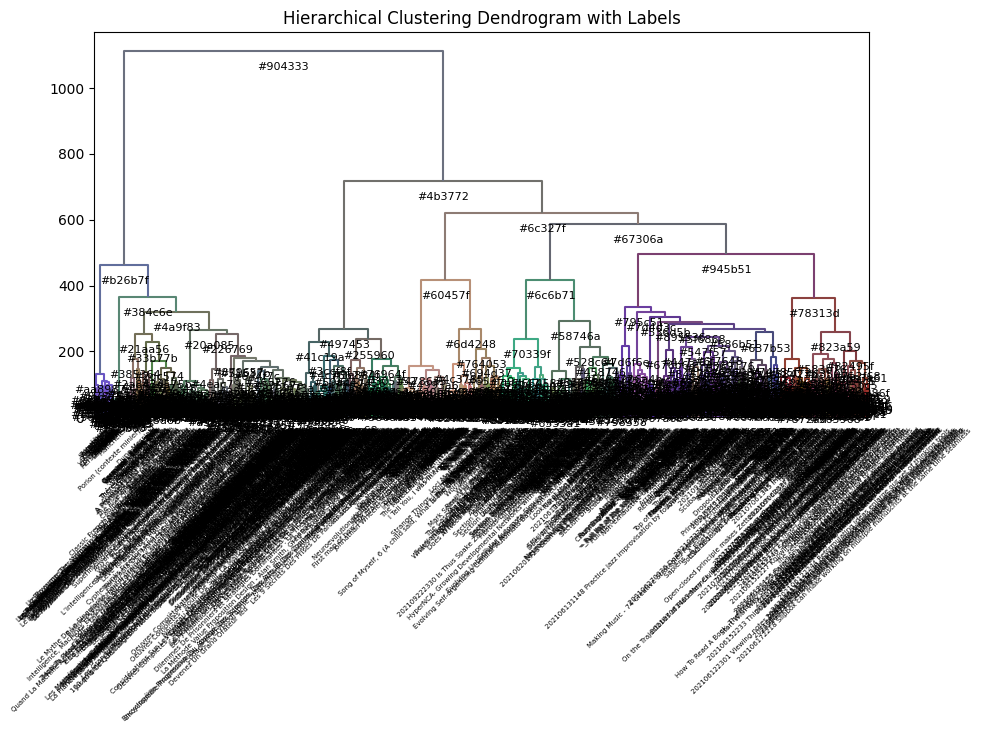

In [13]:
# Extract linkage matrix from linked_df, starting from num_leaves (the first index of the linkage matrix that is not a leaf)
linkage_matrix = linked_df[['id1', 'id2', 'distance', 'size']].values[num_leaves:, :]

# Extract color hex strings from linked_df
link_colors = linked_df['color'].values[num_leaves:]


# Generate the dendrogram with the color hex string labels
plt.figure(figsize=(10, 5))
plt.title("Dendrogram with color hex string labels")

def labeled_dendrogram(link_labels=None, *args, **kwargs):
    if link_labels is None:
        # Sets each link label to the coordinate of the center and its radius
        
        link_labels
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram with Labels')

        for icoord, dcoord, label in zip(ddata['icoord'], ddata['dcoord'], link_labels):
            x = 0.5 * sum(icoord[1:3]) # midpoint of the horizontal line
            y = dcoord[1] # vertical coordinate of the label
            plt.annotate(label, (x, y), xytext=(0, -8),
                            textcoords='offset points',
                            va='top', ha='center', fontsize=8)

    return ddata


dendrogram_data = labeled_dendrogram(link_leaf_colors, linkage_matrix, labels=filenames, leaf_rotation=45, link_color_func=lambda link_id: link_leaf_colors[link_id])
plt.show()


In [ ]:
# Combine all dendrogram code into a function, starting from the embeddings, colors, and filenames
def plot_colored_labeled_dendrogram(embeddings, colors, filenames):
    # Perform hierarchical clustering using the 'ward' method
    linked = linkage(embeddings, method='ward')

# 3D pivot experiment

In [18]:
# for icoord, dcoord, label in zip(dendrogram_data['icoord'], dendrogram_data['dcoord'], link_leaf_colors):
#     x = 0.5 * sum(icoord[1:3]) # midpoint of the horizontal line
#     y = dcoord[1] # vertical coordinate of the label

dendrogram_data['icoord'][0][1:3]

[125.0, 135.0]

In [24]:
def midpoint(icoord):
    return (0.5 * sum(icoord[1:3]), 0)

def radius(icoord):
    return icoord[2] - icoord[1]

def rotate_line(midpoint, radius, theta):
    delta_x = radius * np.cos(theta)
    delta_y = radius * np.sin(theta)

    return [midpoint[0] - delta_x, midpoint[0] + delta_x], [midpoint[1] - delta_y, midpoint[1] + delta_y]

rotate_line(midpoint(dendrogram_data['icoord'][0]), radius(dendrogram_data['icoord'][0]), np.pi / 4)

# plots the 


([22.928932188134524, 37.071067811865476],
 [-7.071067811865475, 7.071067811865475])

In [22]:
dendrogram_data['icoord'][0], dendrogram_data['dcoord'][0]

([25.0, 25.0, 35.0, 35.0], [0.0, 48.20252325613427, 48.20252325613427, 0.0])

In [ ]:
# converts icoord dcoord to midpoint, radius

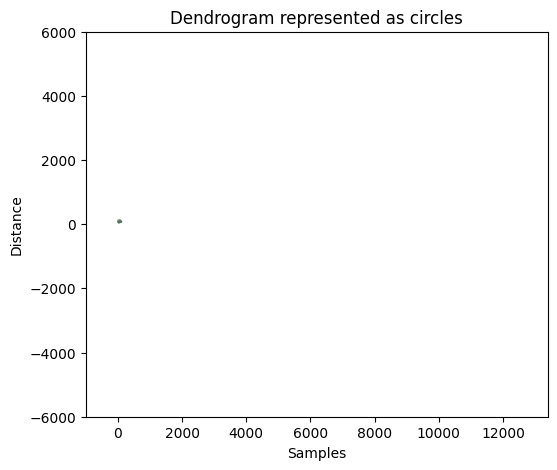

In [39]:
import matplotlib.patches as patches

# Define the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Function to create a circle based on icoord and dcoord
def create_circle(icoord, dcoord, color_hex):
    circle_midpoint = midpoint(icoord, dcoord)
    circle_radius = radius(icoord)
    circle = patches.Circle(circle_midpoint, circle_radius, edgecolor=color_hex, facecolor=color_hex, alpha=0.5)
    ax.add_patch(circle)

# Iterate through dendrogram data and create a circle for each linkage
for icoord, dcoord, color in zip(dendrogram_data['icoord'][:10], dendrogram_data['dcoord'][:10], link_colors[:10]):
    create_circle(icoord, dcoord, color)

# Set the aspect of the plot to equal. This is important, otherwise the circles would be ellipses
ax.set_aspect('equal')
# sets x and y limits to the max and min of the dendrogram
ax.set_xlim(min(dendrogram_data['icoord'][0]), max(dendrogram_data['icoord'][0]))
ax.set_ylim(min(dendrogram_data['dcoord'][0]), max(dendrogram_data['dcoord'][0]))

# Set labels and title
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.title('Dendrogram represented as circles')

plt.show()


---

# Generating Link Topic Labels (Cohere + OpenAI)

---

### Run Clustering above to get linked_df

In [32]:
linked_df

,id1,id2,distance,size,color
0,0.0,0.0,0.000000,1.0,#9d885f
1,1.0,1.0,0.000000,1.0,#1b666e
2,2.0,2.0,0.000000,1.0,#4948a5
3,3.0,3.0,0.000000,1.0,#3e43a3
4,4.0,4.0,0.000000,1.0,#9e7b78
...,...,...,...,...,...
2474,2468.0,2469.0,495.364608,399.0,#7b4070
2475,2472.0,2474.0,587.872737,588.0,#646771
2476,2471.0,2475.0,620.426959,745.0,#8d7b74
2477,2459.0,2476.0,717.706050,903.0,#71706c


### Generate note summaries with cohere

In [ ]:
import src.embed_text_cohere as emb

memory_df = pd.read_csv('./demo_data/memory_embeddings.csv')

my_second_brain_df = pd.read_csv('./demo_data/my_second_brain_embeddings.csv')
